In [2]:
import os
import imageio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import stats, signal
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import seaborn as sns
import cv2 
import pydicom as dicom
import PIL
import skimage as ski
from skimage import segmentation

## Lectura de los datasets

In [3]:
def DicomtoRGB(dicomfile,bt,wt):
    """Create new image(numpy array) filled with certain color in RGB"""
    # Create black blank image
    image = np.zeros((dicomfile.Rows, dicomfile.Columns, 3), np.uint8)
    #loops on image height and width
    i=0
    j=0
    while i<dicomfile.Rows:
        j=0
        while j<dicomfile.Columns:
            color = yaxpb(dicom_file.pixel_array[i][j],bt,wt) #linear transformation to be adapted
            image[i][j] = (color,color,color)## same R,G, B value to obtain greyscale
            j=j+1
        i=i+1
    return image
##linear transformation : from [bt < pxvalue < wt] linear to [0<pyvalue<255]: loss of information... 
def yaxpb(pxvalue,bt,wt):
    if pxvalue < bt:
        y=0
    elif pxvalue > wt:
        y=255
    else:
        y=pxvalue*255/(wt-bt)-255*bt/(wt-bt)
    return y
    

#dicom_file = dicom.read_file("./dataset/1h/POST_EM.dcm")
#wt = dicom_file.LargestImagePixelValue
#bt=0
#image=DicomtoRGB(dicom_file,bt,wt)


In [4]:
def abrir_imagenes(path):
    imagen_ant_em=np.flipud(imageio.imread(path + 'ANT_EM.dcm'))
    imagen_ant_sc=np.flipud(imageio.imread(path + 'ANT_SC.dcm'))
    imagen_pos_em=np.flipud(imageio.imread(path + 'POST_EM.dcm'))
    imagen_pos_sc=np.flipud(imageio.imread(path + 'POST_SC.dcm'))
    meta=imagen_ant_em.meta
    imagen=np.stack((imagen_ant_em,imagen_ant_sc,imagen_pos_em,imagen_pos_sc))
    return imagen, meta

In [7]:
path_dicom_1='dataset/1h/'
path_dicom_15='dataset/15h/'
path_dicom_40='dataset/40h/'
path_dicom_64='dataset/64h/'

In [8]:
imagen_1, meta_1=abrir_imagenes(path_dicom_1)
imagen_15, meta_15=abrir_imagenes(path_dicom_15)
imagen_40, meta_40=abrir_imagenes(path_dicom_40)
imagen_64, meta_64=abrir_imagenes(path_dicom_64)
pos=['ANT_EM','ANT_SC','POST_EM','POST_SC']

* imagen_x guarda los valores de los pixels
* meta_x guarda los meta valores para la imágen EM (son iguales para cada imágen)
* Para cada tiempo la imágen se compone a su vez de 4 imágenes: Anterior EM y SC, y Posterior EM y SC
* Las imágenes se guardan en un tensor donde cada z corresponde a una imánes en el siguiente orden: 
  * ANT_EM [0,:,:]
  * ANT_SC [1,:,:]
  * POST_EM [2,:,:]
  * POST_SC [3,:,:]

In [9]:
n0,n1=meta_1.shape #Tamaño de la imágen
d0,d1=meta_1.sampling #dimension del pixel
x = np.arange(0.0, (n0+1)*d0, d0)
y = np.arange(0.0, (n1+1)*d1, d1)
print ('Las imágnes tienen',n0,'pixeles de alto','y',n1,'pixeles de ancho')
print ('Los pixeles miden',d0,'mm x', d1,'mm')

Las imágnes tienen 1024 pixeles de alto y 256 pixeles de ancho
Los pixeles miden 2.20903 mm x 2.20903 mm


Se computa el máximo para cada serie de datos para cada posición

In [11]:
maximos=[np.max([imagen_1[0,:,:],imagen_15[0,:,:],imagen_40[0,:,:],imagen_64[0,:,:]]),
         np.max([imagen_1[1,:,:],imagen_15[1,:,:],imagen_40[1,:,:],imagen_64[1,:,:]]),
         np.max([imagen_1[2,:,:],imagen_15[2,:,:],imagen_40[2,:,:],imagen_64[2,:,:]]),
         np.max([imagen_1[3,:,:],imagen_15[3,:,:],imagen_40[3,:,:],imagen_64[3,:,:]])]

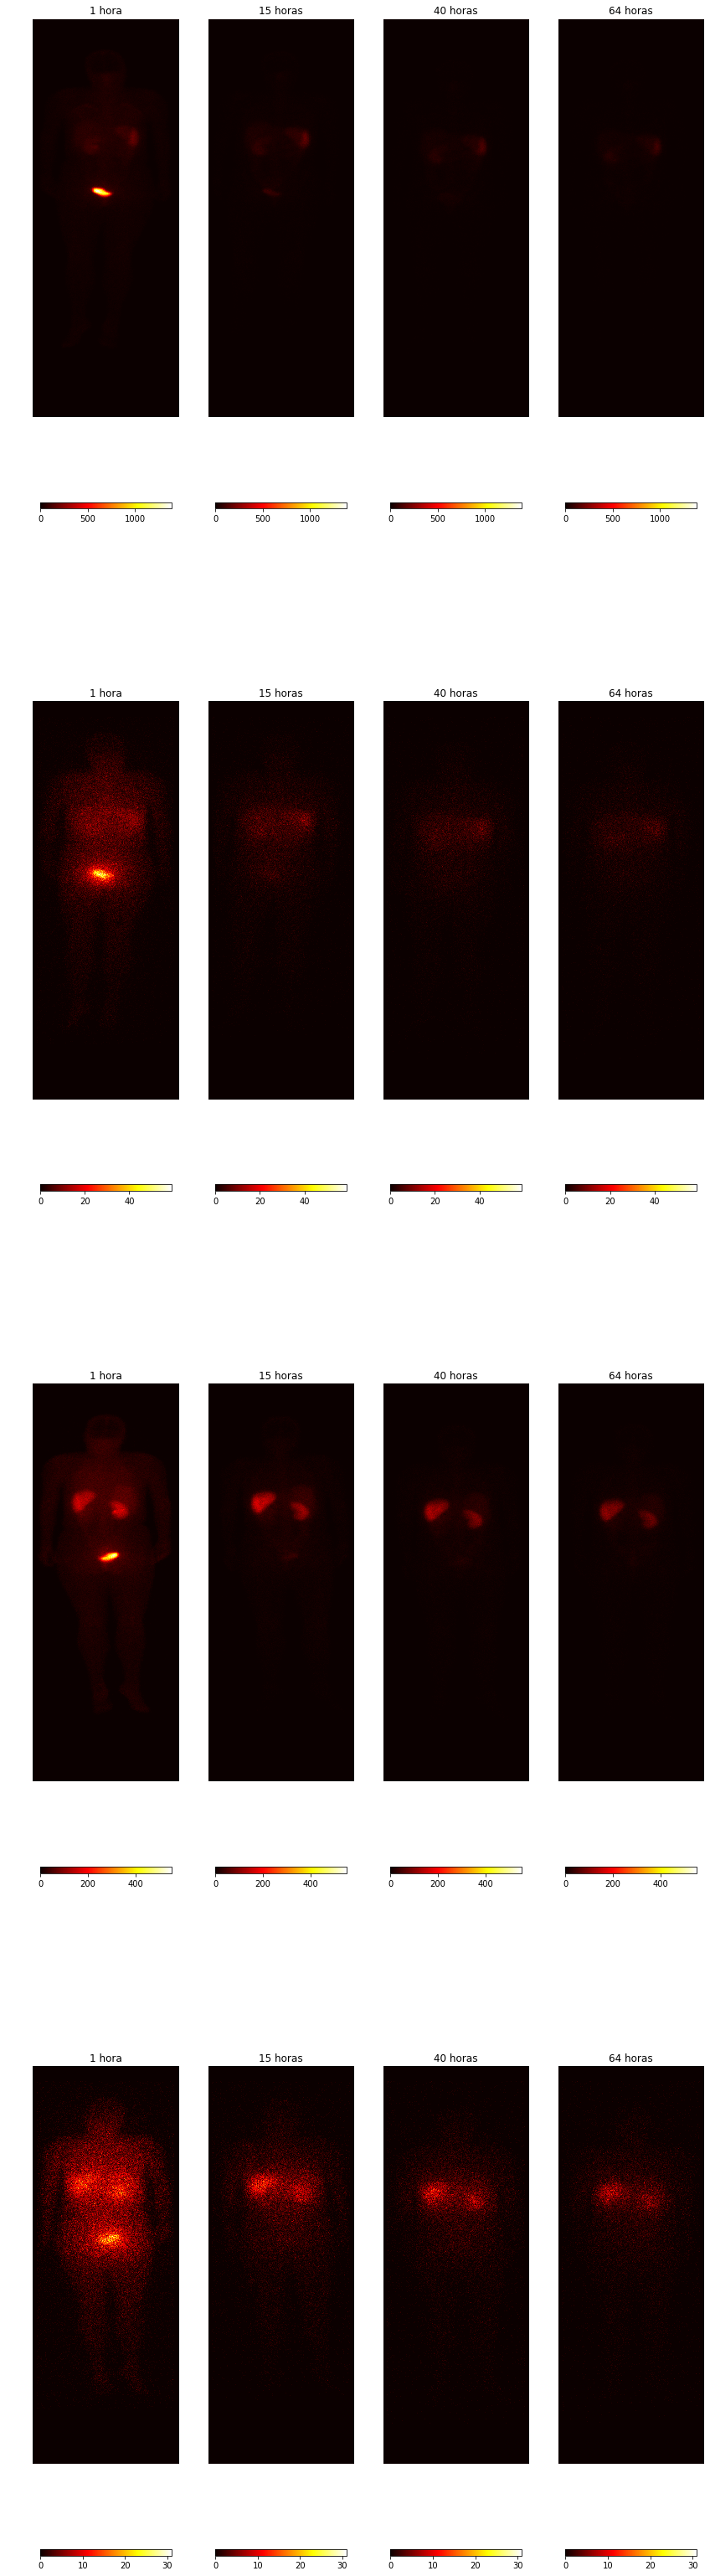

In [13]:
plt.figure(16,figsize=((d1*n1/0.0393701)/1000,(d0*n0/0.0393701)/1000))
j=0
for i in [1,5,9,13]:
    plt.subplot(4,4,i)
    plt.pcolormesh(y,x,imagen_1[j,:,:],cmap='hot',vmax=maximos[j])
    plt.colorbar(orientation='horizontal',shrink=0.9)
    plt.axis('off')
    plt.title('1 hora')
    plt.subplot(4,4,i+1)
    plt.pcolormesh(y,x,imagen_15[j,:,:],cmap='hot',vmax=maximos[j])
    plt.colorbar(orientation='horizontal',shrink=0.9)
    plt.axis('off')
    plt.title('15 horas')
    plt.subplot(4,4,i+2)
    plt.pcolormesh(y,x,imagen_40[j,:,:],cmap='hot',vmax=maximos[j])
    plt.colorbar(orientation='horizontal',shrink=0.9)
    plt.axis('off')
    plt.title('40 horas')    
    plt.subplot(4,4,i+3)
    plt.pcolormesh(y,x,imagen_64[j,:,:],cmap='hot',vmax=maximos[j])
    plt.colorbar(orientation='horizontal',shrink=0.9)
    plt.axis('off')
    plt.title('64 horas')
    j+=1
plt.show()

## 2. Realizar análisis de estadística descriptiva sobre los datos, tanto en una como en múltiples variables. Moda, media, mediana y desviación estándar de un producto en particular.

In [15]:
def descripcion_estadistica(data):
    data=data[np.nonzero(data)]
    mediana=np.median(data)
    media=np.mean(data)
    desv_std=np.std(data)
    moda=stats.mode(data,axis=None)
    resultado=[mediana, media, desv_std, np.asscalar(moda.mode), np.asscalar(moda.count)] 
    return resultado

In [16]:
estadistica_1=np.zeros((4,5))
estadistica_15=np.zeros((4,5))
estadistica_40=np.zeros((4,5))
estadistica_64=np.zeros((4,5))
for i in range(0,4):
        estadistica_1[i,]=(descripcion_estadistica(imagen_1[i,:,:]))
        estadistica_15[i,]=(descripcion_estadistica(imagen_15[i,:,:]))
        estadistica_40[i,]=(descripcion_estadistica(imagen_40[i,:,:]))
        estadistica_64[i,]=(descripcion_estadistica(imagen_64[i,:,:]))
h=['1','15','40','64']
for i in range(0,4):
    for j in range(0,4):
        print('Imágen',h[i],'horas',pos[j])
        print('              Mediana:', '{:.4e}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(0)+']')))
        print('                Media:', '{:.4e}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(1)+']')))
        print('   Deviación estandár:', '{:.4e}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(2)+']')))
        print('                 Moda:', '{:.4e}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(3)+']')))
        print('         Cuentas moda:', '{:.0f}'.format(eval('estadistica_'+h[i]+'['+str(j)+','+str(4)+']')))
        print('------------------------------------------------')

Imágen 1 horas ANT_EM
              Mediana: 1.5000e+01
                Media: 2.2901e+01
   Deviación estandár: 5.6339e+01
                 Moda: 1.0000e+00
         Cuentas moda: 22129
------------------------------------------------
Imágen 1 horas ANT_SC
              Mediana: 2.0000e+00
                Media: 3.7840e+00
   Deviación estandár: 4.2062e+00
                 Moda: 1.0000e+00
         Cuentas moda: 34251
------------------------------------------------
Imágen 1 horas POST_EM
              Mediana: 1.4000e+01
                Media: 1.9960e+01
   Deviación estandár: 2.8446e+01
                 Moda: 1.0000e+00
         Cuentas moda: 23590
------------------------------------------------
Imágen 1 horas POST_SC
              Mediana: 2.0000e+00
                Media: 3.5112e+00
   Deviación estandár: 3.1818e+00
                 Moda: 1.0000e+00
         Cuentas moda: 35737
------------------------------------------------
Imágen 15 horas ANT_EM
              Mediana: 5.0000e+

A continuación se hace un bolxplot teniendo en cuenta los píxels con valor 0 (correspondientes al fondo de la imágen y que no agregan demasiada información) y desestimando los valores de pixel iguales a cero para comparar. Como se ve, cuando se hace un drop de los valores de píxel 0, el valor Q3 - Q1 se incrementa. 

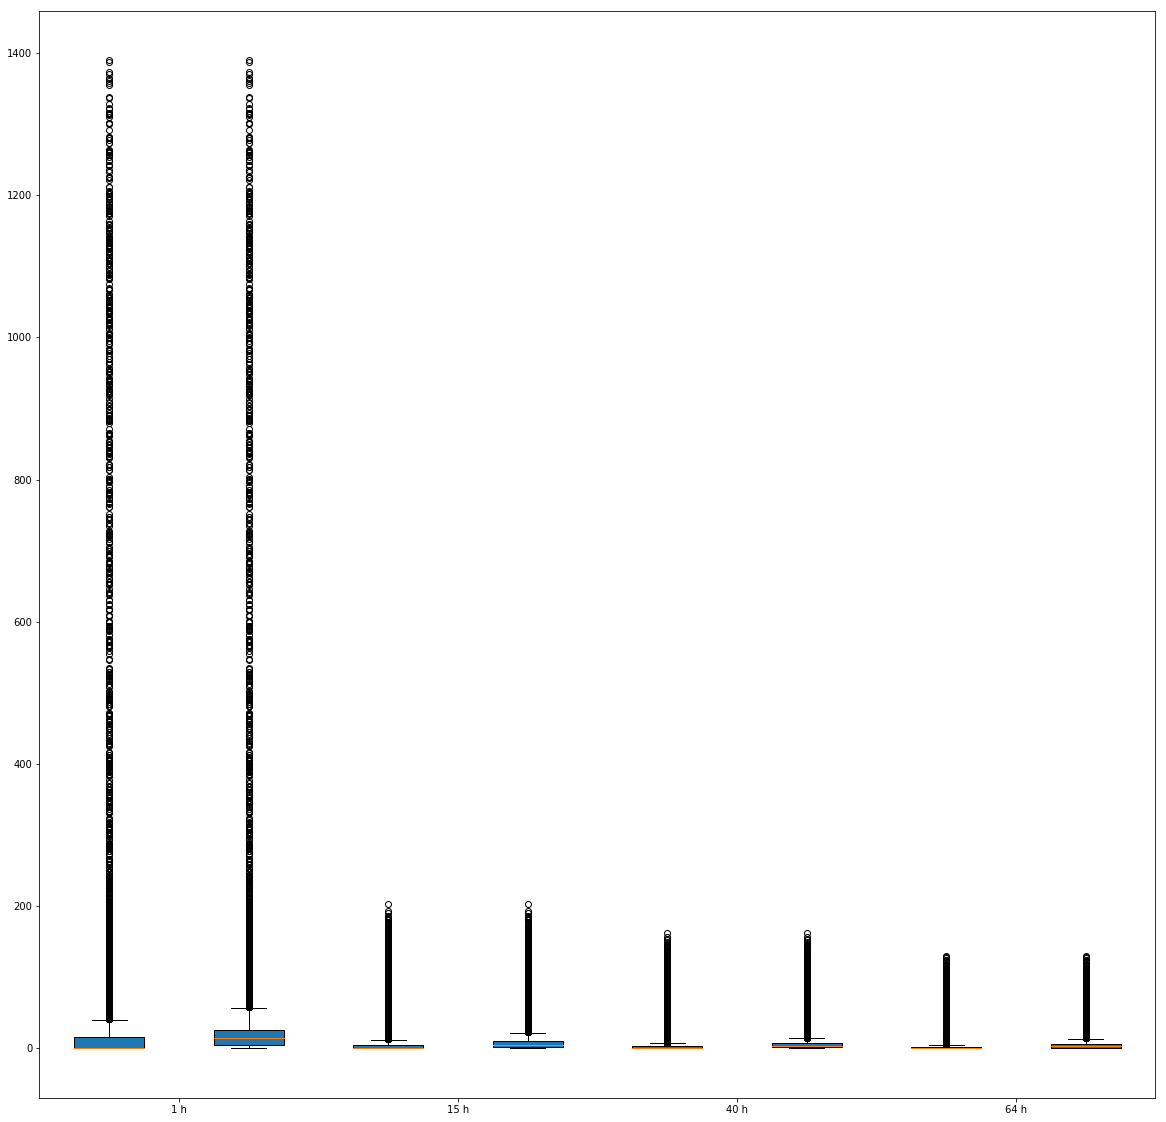

In [17]:

plt.figure(figsize=(20,20))
plt.boxplot([np.ravel(imagen_1[0,:,:]),
             np.ravel(imagen_15[0,:,:]),
             np.ravel(imagen_40[0,:,:]),
             np.ravel(imagen_64[0,:,:]),
             imagen_1[0][np.nonzero(imagen_1[0,:,:])],
             imagen_15[0][np.nonzero(imagen_15[0,:,:])],
             imagen_40[0][np.nonzero(imagen_40[0,:,:])],
             imagen_64[0][np.nonzero(imagen_64[0,:,:])]],
             patch_artist=True,positions=[0,2,4,6,1,3,5,7])

plt.xticks([0.5,2.5,4.5,6.5],['1 h' ,'15 h' ,'40 h' ,'64 h'])
plt.show()

## 3 .Defina de alguna forma la información que pueda considerarse “ruido” y encuentre outliers.##

([<matplotlib.axis.YTick at 0x14c7dcd74780>,
 <a list of 103 Text yticklabel objects>)

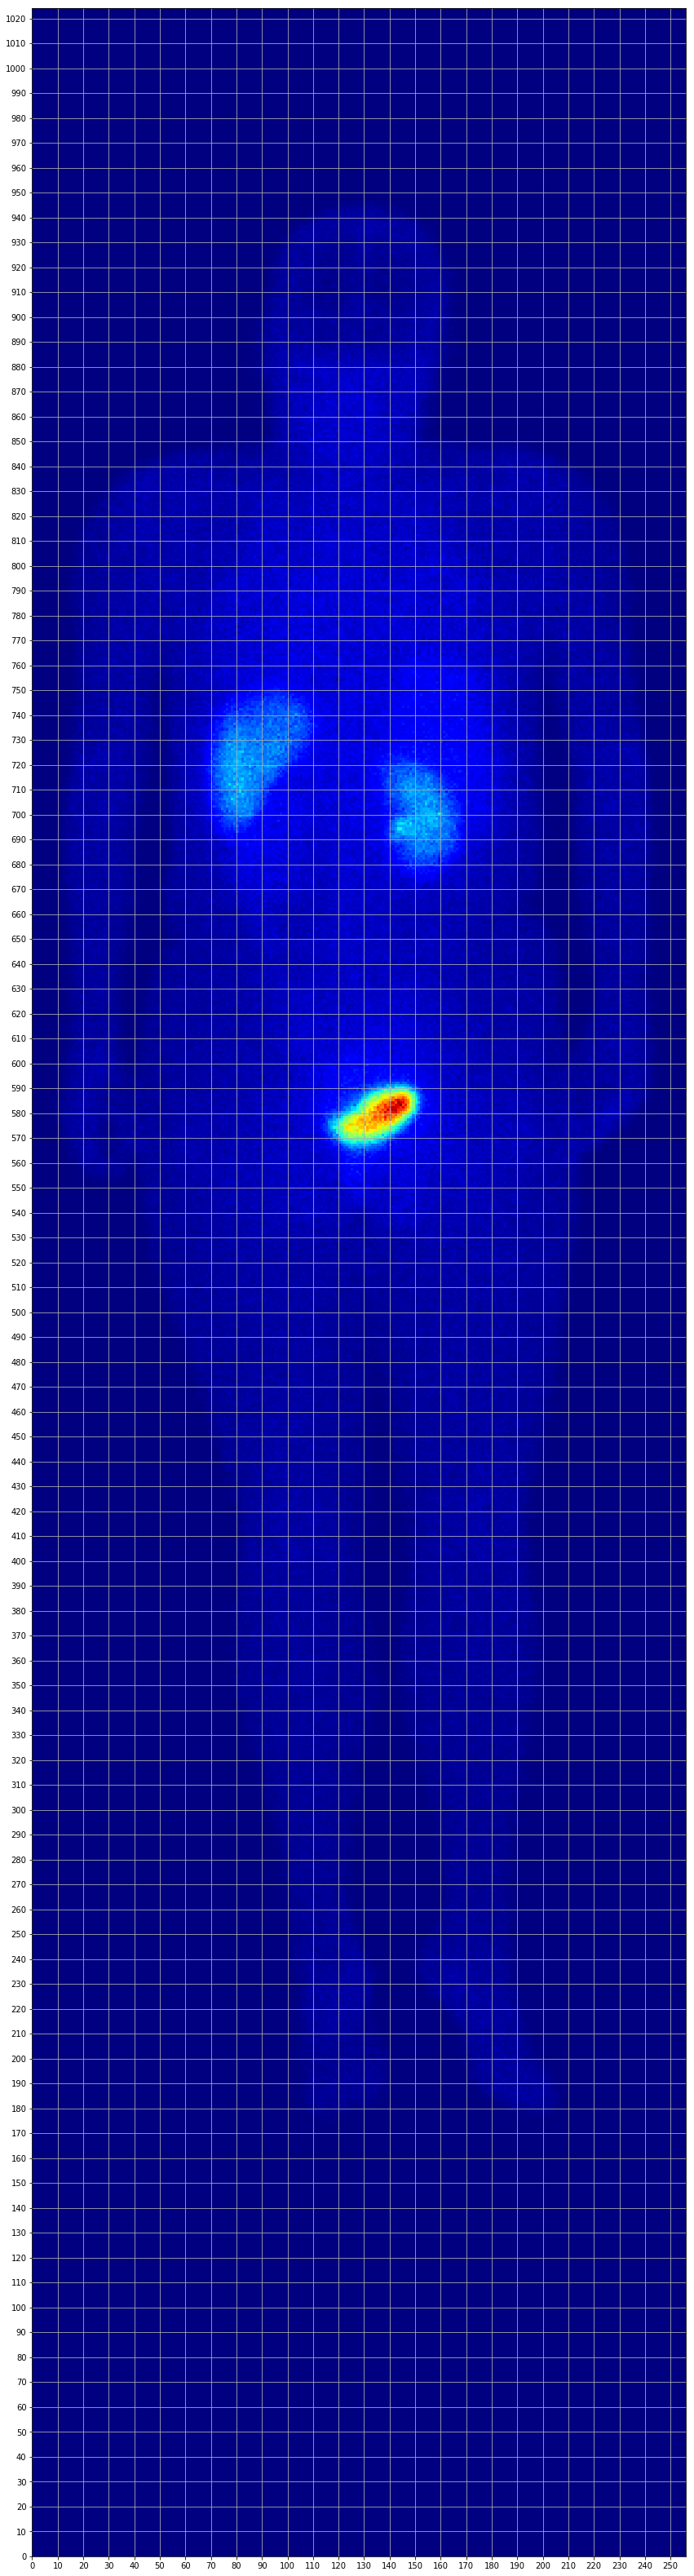

In [19]:
plt.figure(16,figsize=((d1*n1/0.0393701)/1000,(d0*n0/0.0393701)/1000))
plt.pcolormesh(imagen_1[2,:,:],cmap='jet',vmax=maximos[2])
#plt.colorbar(orientation='horizontal')
plt.axis('on')
plt.grid(which='both')
plt.xticks(np.arange(0,256,step=10))
plt.yticks(np.arange(0,1024,step=10))

In [36]:
#roi_1_d=[1024-770, 1024-670, 256-130, 256-60]
#roi_1_i=[1024-770, 1024-670, 256-195, 256-135]
roi_1_d=[685, 755, 65, 115]
roi_1_i=[670, 725, 135, 170]
roi_2=[560, 600, 110, 155]
roi_3=[610, 660, 95, 145]
roi_4=[840, 860,120, 140]

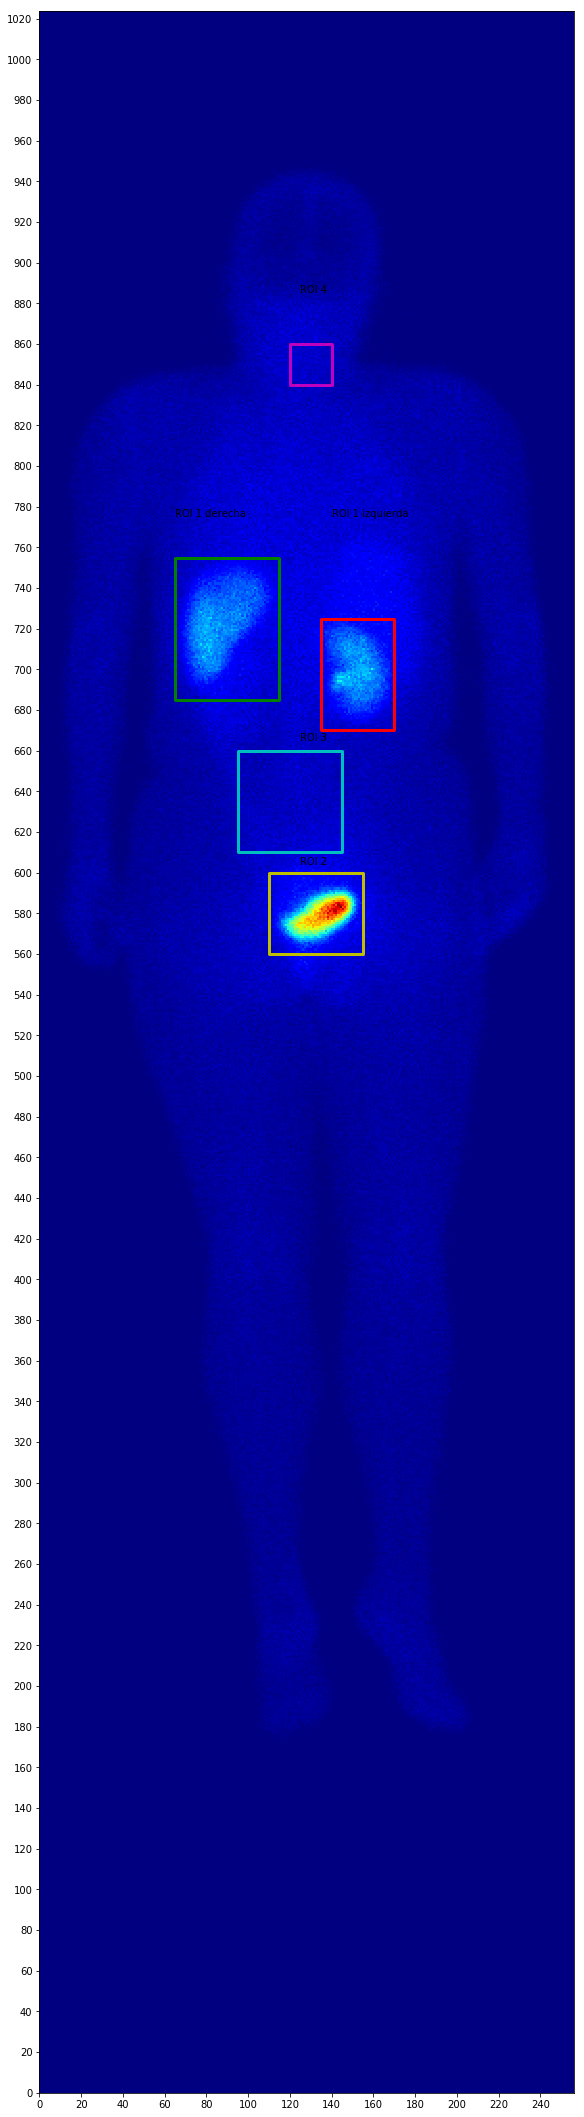

In [40]:

plt.figure(16,figsize=((d1*n1/0.0393701)/1500,(d0*n0/0.0393701)/1500))
plt.pcolormesh(imagen_1[2,:,:],cmap='jet',vmax=maximos[2])
plt.axis('on')
#plt.grid(which='both')
plt.xticks(np.arange(0,256,step=20))
plt.yticks(np.arange(0,1024,step=20))

ax = plt.gca()
patches=[]

# Creo un Rectangle patch para cada ROI
roi1i = mpatches.Rectangle((135,670),35,55)
plt.text(140,775,'ROI 1 izquierda')
patches.append(roi1i)

roi1d = mpatches.Rectangle((65,685),50,70)
plt.text(65,775,'ROI 1 derecha')
patches.append(roi1d)

roi2 = mpatches.Rectangle((110,560),45,40)
plt.text(125,1024-420,'ROI 2')
patches.append(roi2)

roi3 = mpatches.Rectangle((95,610),50,50)
plt.text(125,665,'ROI 3')
patches.append(roi3)

roi4 = mpatches.Rectangle((120,840),20,20)
plt.text(125,885,'ROI 4')
patches.append(roi4)
edgecolors=['r','g','y','c','m']
collection = PatchCollection(patches,facecolor='none',edgecolor=edgecolors,linewidth=3)
ax.add_collection(collection)

In [47]:
R1_d_imagen_1=imagen_1[2,roi_1_d[0]:roi_1_d[1],roi_1_d[2]:roi_1_d[3]]
R1_i_imagen_1=imagen_1[2,roi_1_i[0]:roi_1_i[1],roi_1_i[2]:roi_1_i[3]]
R2_imagen_1=imagen_1[2,roi_2[0]:roi_2[1],roi_2[2]:roi_2[3]]
R3_imagen_1=imagen_1[2,roi_3[0]:roi_3[1],roi_3[2]:roi_3[3]]
R4_imagen_1=imagen_1[2,roi_4[0]:roi_4[1],roi_4[2]:roi_4[3]]

R1_d_imagen_15=imagen_15[2,roi_1_d[0]:roi_1_d[1],roi_1_d[2]:roi_1_d[3]]
R1_i_imagen_15=imagen_15[2,roi_1_i[0]:roi_1_i[1],roi_1_i[2]:roi_1_i[3]]
R2_imagen_15=imagen_15[2,roi_2[0]:roi_2[1],roi_2[2]:roi_2[3]]
R3_imagen_15=imagen_15[2,roi_3[0]:roi_3[1],roi_3[2]:roi_3[3]]
R4_imagen_15=imagen_15[2,roi_4[0]:roi_4[1],roi_4[2]:roi_4[3]]

R1_d_imagen_40=imagen_40[2,roi_1_d[0]:roi_1_d[1],roi_1_d[2]:roi_1_d[3]]
R1_i_imagen_40=imagen_40[2,roi_1_i[0]:roi_1_i[1],roi_1_i[2]:roi_1_i[3]]
R2_imagen_40=imagen_40[2,roi_2[0]:roi_2[1],roi_2[2]:roi_2[3]]
R3_imagen_40=imagen_40[2,roi_3[0]:roi_3[1],roi_3[2]:roi_3[3]]
R4_imagen_40=imagen_40[2,roi_4[0]:roi_4[1],roi_4[2]:roi_4[3]]

R1_d_imagen_64=imagen_64[2,roi_1_d[0]:roi_1_d[1],roi_1_d[2]:roi_1_d[3]]
R1_i_imagen_64=imagen_64[2,roi_1_i[0]:roi_1_i[1],roi_1_i[2]:roi_1_i[3]]
R2_imagen_64=imagen_64[2,roi_2[0]:roi_2[1],roi_2[2]:roi_2[3]]
R3_imagen_64=imagen_64[2,roi_3[0]:roi_3[1],roi_3[2]:roi_3[3]]
R4_imagen_64=imagen_64[2,roi_4[0]:roi_4[1],roi_4[2]:roi_4[3]]

Como ruido, tomamos la media de valor de los píxels contenidos en las ROI3 y ROI4 más tres desvíos standar.

In [60]:
def fondo(ruido):
    promedio_ruido=np.mean(ruido)
    return promedio_ruido+3*np.std(ruido)

ruido=np.concatenate((np.ravel(R3_imagen_1),np.ravel(R4_imagen_1)),axis=None)
bkg_1=fondo(ruido)

ruido=np.concatenate((np.ravel(R3_imagen_15),np.ravel(R4_imagen_15)),axis=None)
bkg_15=fondo(ruido)

ruido=np.concatenate((np.ravel(R3_imagen_40),np.ravel(R4_imagen_40)),axis=None)
bkg_40=fondo(ruido)

ruido=np.concatenate((np.ravel(R3_imagen_64),np.ravel(R4_imagen_64)),axis=None)
bkg_64=fondo(ruido)

In [61]:
R1_d_imagen_1_lim=R1_d_imagen_1*(R1_d_imagen_1>bkg_1)*1.0
R1_i_imagen_1_lim=R1_i_imagen_1*(R1_i_imagen_1>bkg_1)*1.0
R2_imagen_1_lim=R2_imagen_1*(R2_imagen_1>bkg_1)*1.0
R3_imagen_1_lim=R3_imagen_1*(R3_imagen_1>bkg_1)*1.0
R4_imagen_1_lim=R4_imagen_1*(R4_imagen_1>bkg_1)*1.0

R1_d_imagen_15_lim=R1_d_imagen_15*(R1_d_imagen_15>bkg_15)*1.0
R1_i_imagen_15_lim=R1_i_imagen_15*(R1_i_imagen_15>bkg_15)*1.0
R2_imagen_15_lim=R2_imagen_15*(R2_imagen_15>bkg_15)*1.0
R3_imagen_15_lim=R3_imagen_15*(R3_imagen_15>bkg_15)*1.0
R4_imagen_15_lim=R4_imagen_15*(R4_imagen_15>bkg_15)*1.0

R1_d_imagen_40_lim=R1_d_imagen_40*(R1_d_imagen_40>bkg_40)*1.0
R1_i_imagen_40_lim=R1_i_imagen_40*(R1_i_imagen_40>bkg_40)*1.0
R2_imagen_40_lim=R2_imagen_40*(R2_imagen_40>bkg_40)*1.0
R3_imagen_40_lim=R3_imagen_40*(R3_imagen_40>bkg_40)*1.0
R4_imagen_40_lim=R4_imagen_40*(R4_imagen_40>bkg_40)*1.0

R1_d_imagen_64_lim=R1_d_imagen_64*(R1_d_imagen_64>bkg_64)*1.0
R1_i_imagen_64_lim=R1_i_imagen_64*(R1_i_imagen_64>bkg_64)*1.0
R2_imagen_64_lim=R2_imagen_64*(R2_imagen_64>bkg_64)*1.0
R3_imagen_64_lim=R3_imagen_64*(R3_imagen_64>bkg_64)*1.0
R4_imagen_64_lim=R4_imagen_64*(R4_imagen_64>bkg_64)*1.0

In [62]:
imagen_1_lim=imagen_1*(imagen_1>bkg_1)*1.0
imagen_15_lim=imagen_15*(imagen_15>bkg_15)*1.0
imagen_40_lim=imagen_40*(imagen_40>bkg_40)*1.0
imagen_64_lim=imagen_64*(imagen_64>bkg_64)*1.0

A la izquierda observamos la imagen de la vejiga limpia, y a la derecha la normal.

<Figure size 432x288 with 0 Axes>

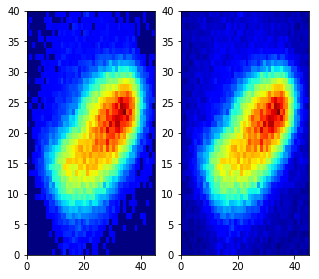

In [63]:
l ,h=np.shape(R2_imagen_1_lim)
plt.figure()
plt.subplots(1,2,figsize=((d1*h/0.0393701)/500,(d0*l/0.0393701)/500))
plt.subplot(1,2,1)
plt.pcolormesh(R2_imagen_1_lim,cmap='jet',vmax=maximos[2])
plt.subplot(1,2,2)
plt.pcolormesh(R2_imagen_1,cmap='jet',vmax=maximos[2])
plt.show()

Las siguientes son las imágenes obtenidas luego de filtrar los valores que señalamos como ruido (izquierda) y sin filtrar los valores considerados como ruido (derecha).

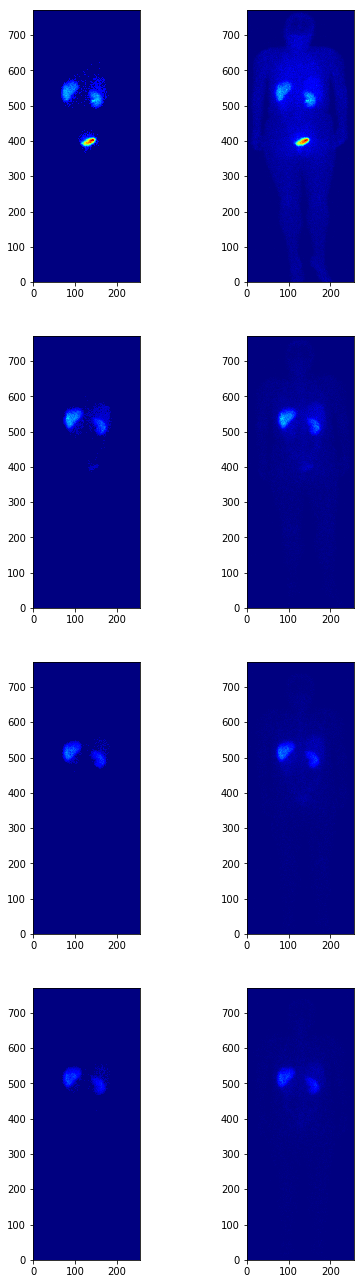

In [67]:
#plt.figure(figsize=(30,30))
plt.figure(figsize=(2*(d1*n1/0.0393701)/5000,2*(d0*n0/0.0393701)/5000))
#plt.subplots(1,2,figsize=((d1*n1/0.0393701)/2000,(d0*n0/0.0393701)/2000))
plt.subplot(4,2,1)
plt.pcolormesh(imagen_1_lim[2,180:950,:],cmap='jet',vmax=maximos[2])
plt.subplot(4,2,2)
plt.pcolormesh(imagen_1[2,180:950,:],cmap='jet',vmax=maximos[2])

plt.subplot(4,2,3)
plt.pcolormesh(imagen_15_lim[2,180:950,:],cmap='jet',vmax=maximos[2])
plt.subplot(4,2,4)
plt.pcolormesh(imagen_15[2,180:950,:],cmap='jet',vmax=maximos[2])

plt.subplot(4,2,5)
plt.pcolormesh(imagen_40_lim[2,180:950,:],cmap='jet',vmax=maximos[2])
plt.subplot(4,2,6)
plt.pcolormesh(imagen_40[2,180:950,:],cmap='jet',vmax=maximos[2])

plt.subplot(4,2,7)
plt.pcolormesh(imagen_64_lim[2,180:950,:],cmap='jet',vmax=maximos[2])
plt.subplot(4,2,8)
plt.pcolormesh(imagen_64[2,180:950,:],cmap='jet',vmax=maximos[2])

plt.subplots_adjust(wspace=1)
plt.show()

A continuación los gráficos de violín de las imágenes sin limpiar (derecha) y limpias (izquierda).

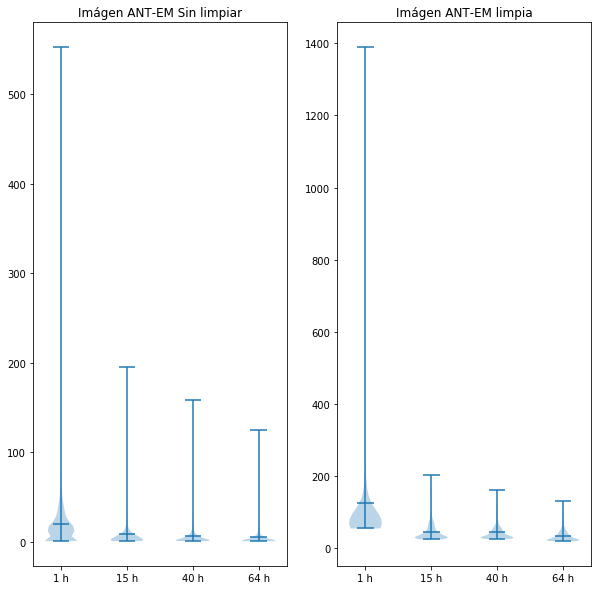

In [69]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.violinplot([imagen_1[2][np.nonzero(imagen_1[2,:,:])],
             imagen_15[2][np.nonzero(imagen_15[2,:,:])],
             imagen_40[2][np.nonzero(imagen_40[2,:,:])],
             imagen_64[2][np.nonzero(imagen_64[2,:,:])]],
             showmeans=True)
plt.xticks([1,2,3,4],['1 h' ,'15 h' ,'40 h' ,'64 h'])
plt.title('Imágen ANT-EM Sin limpiar')

plt.subplot(1,2,2)
plt.violinplot([imagen_1_lim[0][np.nonzero(imagen_1_lim[0,:,:])],
             imagen_15_lim[0][np.nonzero(imagen_15_lim[0,:,:])],
             imagen_40_lim[0][np.nonzero(imagen_40_lim[0,:,:])],
             imagen_64_lim[0][np.nonzero(imagen_64_lim[0,:,:])]],
             showmeans=True)
plt.xticks([1,2,3,4],['1 h' ,'15 h' ,'40 h' ,'64 h'])
plt.title('Imágen ANT-EM limpia')
plt.show()



## 4.Agrupe en un número que considere aceptable los datos de cada imagen y busque coeficientes de correlación entre grupos del mismo tiempo y grupos de distintos tiempos. Definido un conjunto de píxeles dentro de un grupo en la primera imagen, este grupo de píxeles debe pertenecer al mismo grupo en los tiempos siguientes.

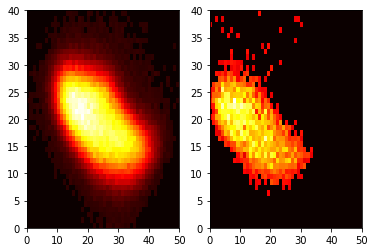

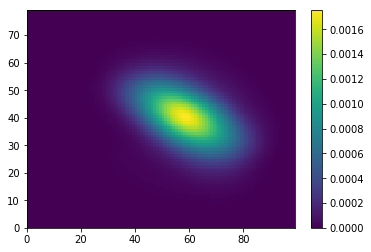

In [21]:
plt.figure()
plt.subplot(1,2,1)
plt.pcolormesh(R2_imagen_1_lim,cmap='hot')
plt.subplot(1,2,2)
plt.pcolormesh(R2_imagen_15_lim,cmap='hot')
plt.figure()
plt.pcolormesh(signal.correlate2d(R2_imagen_1_lim,R2_imagen_15_lim))
plt.colorbar()
plt.show()

## 5.Defina un criterio para poder dividir los datos en cada imagen en sub-regiones que pueda considerar “homogéneas”.

In [22]:
R2_imagen_1_lim.shape

(40, 50)

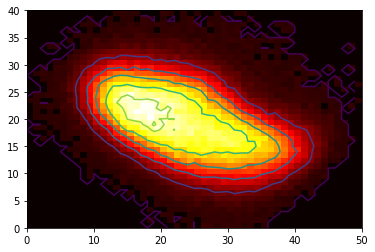

In [23]:
plt.pcolormesh(R2_imagen_1_lim,cmap='hot')
plt.contour(R2_imagen_1_lim)